# Hotel Booking Cancellation Prediction

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

import xgboost as xgb

from IPython.display import display
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
SEED = 1
N_JOBS = -1

In [3]:
df = pd.read_csv('hotel_reservations.csv')
df.head()

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


In [4]:
df.shape

(36275, 19)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

## Data Preparation

In [6]:
# drop not relevant columns
df = df.drop(columns=['Booking_ID', 'arrival_year'])
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,4,11,Online,0,0,0,94.50,0,Canceled


In [7]:
categorical = [*df.dtypes[df.dtypes == 'object'].index]
categorical

['type_of_meal_plan',
 'room_type_reserved',
 'market_segment_type',
 'booking_status']

In [8]:
# harmonize values in categorical variables
for c in categorical:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df[categorical].head().T

,0,1,2,3,4
type_of_meal_plan,meal_plan_1,not_selected,meal_plan_1,meal_plan_1,not_selected
room_type_reserved,room_type_1,room_type_1,room_type_1,room_type_1,room_type_1
market_segment_type,offline,online,online,online,online
booking_status,not_canceled,not_canceled,canceled,canceled,canceled


In [9]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,meal_plan_1,0,room_type_1,224,10,2,offline,0,0,0,65.00,0,not_canceled
1,2,0,2,3,not_selected,0,room_type_1,5,11,6,online,0,0,0,106.68,1,not_canceled
2,1,0,2,1,meal_plan_1,0,room_type_1,1,2,28,online,0,0,0,60.00,0,canceled
3,2,0,0,2,meal_plan_1,0,room_type_1,211,5,20,online,0,0,0,100.00,0,canceled
4,2,0,1,1,not_selected,0,room_type_1,48,4,11,online,0,0,0,94.50,0,canceled


In [10]:
df['booking_status'].value_counts()

booking_status
not_canceled    24390
canceled        11885
Name: count, dtype: int64

In [11]:
df['booking_status'] = (df['booking_status'] == 'canceled').astype(int)

In [12]:
df.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,meal_plan_1,0,room_type_1,224,10,2,offline,0,0,0,65.00,0,0
1,2,0,2,3,not_selected,0,room_type_1,5,11,6,online,0,0,0,106.68,1,0
2,1,0,2,1,meal_plan_1,0,room_type_1,1,2,28,online,0,0,0,60.00,0,1
3,2,0,0,2,meal_plan_1,0,room_type_1,211,5,20,online,0,0,0,100.00,0,1
4,2,0,1,1,not_selected,0,room_type_1,48,4,11,online,0,0,0,94.50,0,1


In [13]:
df.isnull().sum()

no_of_adults                            0
no_of_children                          0
no_of_weekend_nights                    0
no_of_week_nights                       0
type_of_meal_plan                       0
required_car_parking_space              0
room_type_reserved                      0
lead_time                               0
arrival_month                           0
arrival_date                            0
market_segment_type                     0
repeated_guest                          0
no_of_previous_cancellations            0
no_of_previous_bookings_not_canceled    0
avg_price_per_room                      0
no_of_special_requests                  0
booking_status                          0
dtype: int64

## Validation Framework

In [14]:
# split dataset into train/validation/test datasets with 60%/20%/20% distribution
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)

In [15]:
assert len(df) == len(df_train) + len(df_val) + len(df_test)

In [16]:
len(df_train), len(df_val), len(df_test)

(21765, 7255, 7255)

In [17]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [18]:
y_train = df_train['booking_status'].values
y_val = df_val['booking_status'].values
y_test = df_test['booking_status'].values

In [19]:
del df_train['booking_status']
del df_val['booking_status']
del df_test['booking_status']

## EDA

In [20]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,1,0,2,3,meal_plan_1,0,room_type_1,115,2,27,offline,0,0,0,76.00,0,0
1,2,0,2,1,meal_plan_2,0,room_type_1,131,8,15,offline,0,0,0,94.50,0,0
2,2,0,1,0,meal_plan_1,0,room_type_4,16,9,26,online,0,0,0,164.00,0,1
3,2,0,2,2,meal_plan_2,0,room_type_1,169,4,22,offline,0,0,0,106.00,0,1
4,1,0,1,0,meal_plan_1,1,room_type_1,5,12,5,complementary,1,2,8,0.00,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29015,2,0,2,1,meal_plan_1,0,room_type_1,66,11,12,online,0,0,0,105.33,1,1
29016,2,0,0,2,meal_plan_1,0,room_type_1,70,4,22,online,0,0,0,105.30,1,1
29017,1,0,1,2,meal_plan_1,0,room_type_1,24,6,6,online,0,0,0,120.00,0,1
29018,2,2,1,1,meal_plan_1,0,room_type_6,3,3,21,online,0,0,0,181.00,0,0


In [21]:
df_full_train['booking_status'].mean()

0.3286354238456237

In [22]:
categorical = [
    'type_of_meal_plan',
    'required_car_parking_space',
    'room_type_reserved',
    'arrival_month',
    'arrival_date',
    'market_segment_type',
    'repeated_guest'
]

In [23]:
numerical = [
    'no_of_adults',
    'no_of_children',
    'no_of_weekend_nights',
    'no_of_week_nights',
    'lead_time',
    'no_of_previous_cancellations',
    'no_of_previous_bookings_not_canceled',
    'avg_price_per_room',
    'no_of_special_requests'
]

### Feature Importance: Cancellation rate and Risk ratio

In [24]:
global_cancellation_rate = df_full_train['booking_status'].mean()
global_cancellation_rate

0.3286354238456237

In [25]:
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).booking_status.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_cancellation_rate
    df_group['risk'] = df_group['mean'] / global_cancellation_rate
    display(df_group)
    print('\n\n')

type_of_meal_plan


,mean,count,diff,risk
type_of_meal_plan,,,,
meal_plan_1,0.312264,22244,-0.016371,0.950184
meal_plan_2,0.459459,2664,0.130824,1.398083
meal_plan_3,0.200000,5,-0.128635,0.608577
not_selected,0.332603,4107,0.003967,1.012072





required_car_parking_space


,mean,count,diff,risk
required_car_parking_space,,,,
0,0.336060,28114,0.007425,1.022593
1,0.098234,906,-0.230401,0.298915





room_type_reserved


,mean,count,diff,risk
room_type_reserved,,,,
room_type_1,0.323350,22505,-0.005285,0.983918
room_type_2,0.333925,563,0.005290,1.016097
room_type_3,0.333333,6,0.004698,1.014295
room_type_4,0.341352,4822,0.012717,1.038696
room_type_5,0.275701,214,-0.052934,0.838926
room_type_6,0.425641,780,0.097006,1.295177
room_type_7,0.253846,130,-0.074789,0.772425





arrival_month


,mean,count,diff,risk
arrival_month,,,,
1,0.023428,811,-0.305208,0.071288
2,0.247619,1365,-0.081016,0.753476
3,0.302350,1872,-0.026285,0.920018
4,0.365621,2199,0.036985,1.112542
5,0.369534,2081,0.040898,1.124449
6,0.398093,2517,0.069458,1.211351
7,0.447582,2337,0.118947,1.361942
8,0.390069,3061,0.061433,1.186934
9,0.343227,3706,0.014592,1.044401





arrival_date


,mean,count,diff,risk
arrival_date,,,,
1,0.391211,933,0.062576,1.190411
2,0.236891,1068,-0.091744,0.720833
3,0.358314,854,0.029678,1.090308
4,0.359665,1076,0.031030,1.094421
5,0.291807,891,-0.036828,0.887935
6,0.351190,1008,0.022555,1.068632
7,0.334862,872,0.006227,1.018948
8,0.299270,959,-0.029365,0.910645
9,0.255763,911,-0.072873,0.778257





market_segment_type


,mean,count,diff,risk
market_segment_type,,,,
aviation,0.290000,100,-0.038635,0.882437
complementary,0.000000,305,-0.328635,0.000000
corporate,0.114127,1621,-0.214508,0.347276
offline,0.297832,8394,-0.030804,0.906268
online,0.366828,18600,0.038193,1.116216





repeated_guest


,mean,count,diff,risk
repeated_guest,,,,
0,0.336822,28279,0.008187,1.024912
1,0.016194,741,-0.312441,0.049277


### Feature Importance: Mutual information

In [26]:
def mutual_info_cancellation_score(series):
    return mutual_info_score(series, df_full_train['booking_status'])

In [27]:
mi = df_full_train[categorical].apply(mutual_info_cancellation_score)
mi.sort_values(ascending=False)

arrival_month                 0.022822
market_segment_type           0.013890
repeated_guest                0.008502
required_car_parking_space    0.004723
arrival_date                  0.004275
type_of_meal_plan             0.003861
room_type_reserved            0.000769
dtype: float64

### Feature Importance: Correlation

In [28]:
df_full_train[numerical].corrwith(df_full_train['booking_status']).abs().sort_values(ascending=False)

lead_time                               0.438241
no_of_special_requests                  0.251734
avg_price_per_room                      0.146501
no_of_adults                            0.091589
no_of_week_nights                       0.091316
no_of_weekend_nights                    0.062028
no_of_previous_bookings_not_canceled    0.060505
no_of_children                          0.036285
no_of_previous_cancellations            0.035677
dtype: float64

### Feature Importnace: Feature elimination

We can employ Logistic Regression as a test model to assess how removing a feature affects the AUC score.

In [29]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [30]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=SEED)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=1, solver='liblinear')

In [31]:
y_pred = model.predict_proba(X_val)[:, 1]
original_auc_score = roc_auc_score(y_val, y_pred)
round(original_auc_score, 2)

0.86

In [32]:
features = [*df_train.columns]

for f in features:
    df_train_copy = df_train.drop(columns=[f])
    df_val_copy = df_val.drop(columns=[f])

    dv = DictVectorizer(sparse=False)
    train_dict = df_train_copy.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)
    val_dict = df_val_copy.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=SEED)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    
    auc_score = roc_auc_score(y_val, y_pred)
    
    print(f'The auc_score without {f} is {auc_score:.2f}')

The auc_score without no_of_adults is 0.86
The auc_score without no_of_children is 0.86
The auc_score without no_of_weekend_nights is 0.86
The auc_score without no_of_week_nights is 0.86
The auc_score without type_of_meal_plan is 0.86
The auc_score without required_car_parking_space is 0.86
The auc_score without room_type_reserved is 0.86
The auc_score without lead_time is 0.75
The auc_score without arrival_month is 0.86
The auc_score without arrival_date is 0.86
The auc_score without market_segment_type is 0.84
The auc_score without repeated_guest is 0.86
The auc_score without no_of_previous_cancellations is 0.86
The auc_score without no_of_previous_bookings_not_canceled is 0.86
The auc_score without avg_price_per_room is 0.85
The auc_score without no_of_special_requests is 0.81


We observe that only lead_time, market_segment_type, avg_price_per_room, and no_of_special_requests have an impact on the AUC score.

Following the Feature Importance analysis, we can eliminate features that do not influence the model.

In [33]:
# final list of features
features = ['lead_time', 'arrival_month', 'market_segment_type', 'avg_price_per_room', 'no_of_special_requests']

## Model Training

In [34]:
def fit_dv(df_dict):
    dv = DictVectorizer(sparse=False)
    dv.fit(df_dict)
    return dv


In [35]:
def prepare_X(df_dict, dv):
    X = dv.transform(df_dict)
    return X

In [36]:
def train_logistic_regression(X, Y, solver='liblinear', C=1.0, max_iter=1000, random_state=SEED):
    model = LogisticRegression(solver=solver, C=C, max_iter=max_iter, random_state=random_state)
    model.fit(X, Y)
    return model

In [37]:
def train_decision_tree(X, Y, max_depth=None, min_samples_leaf=1, random_state=SEED):
    model = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=random_state)
    model.fit(X, Y)
    return model

In [38]:
def train_random_forest(X, Y, n_estimators=100, max_depth=None, min_samples_leaf=1, random_state=SEED, n_jobs=N_JOBS):
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,
                                   min_samples_leaf=min_samples_leaf, random_state=random_state, n_jobs=n_jobs)
    model.fit(X, Y)
    return model

In [39]:
def predict(X, model):
    y_pred = model.predict_proba(X)[:, 1]
    return y_pred

In [40]:
def construct_dmatrix(X, label=None, feature_names=None):
    return xgb.DMatrix(X, label=label, feature_names=feature_names)

In [41]:
def train_xgboost(dtrain, xgb_params, num_boost_round=10, verbose_eval=True, evals=None):
    model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_round,
                      verbose_eval=verbose_eval, evals=evals)
    return model

In [42]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    return results

In [43]:
df_train = df_train[features]
df_val = df_val[features]

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

### Logistic Regression: 5-Fold Cross-Validation

In [44]:
kfold = KFold(n_splits=5, shuffle=True, random_state=SEED)

In [45]:
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train_temp = df_full_train.iloc[train_idx]
    df_val_temp = df_full_train.iloc[val_idx]

    y_train_temp = df_train_temp['booking_status'].values
    y_val_temp = df_val_temp['booking_status'].values

    df_train_temp = df_train_temp[features]
    df_val_temp = df_val_temp[features]

    train_dict_temp = df_train_temp.to_dict(orient='records')
    val_dict_temp = df_val_temp.to_dict(orient='records')

    dv = fit_dv(train_dict_temp)
    X_train = prepare_X(train_dict_temp, dv)
    model = train_logistic_regression(X_train, y_train_temp)
    X_val = prepare_X(val_dict_temp, dv)
    y_pred = predict(X_val, model)

    auc = roc_auc_score(y_val_temp, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

In [46]:
np.mean(scores).round(3), np.std(scores).round(3)

(0.857, 0.004)

### Logistic Regression: Parameters Tuning

In [47]:
C = [0.01, 0.1, 0.5, 10]

mean_scores = []

for c in tqdm(C, desc='C'):
    scores = []
    
    for train_idx, val_idx in tqdm(kfold.split(df_full_train), desc='k', leave=False):
        df_train_temp = df_full_train.iloc[train_idx]
        df_val_temp = df_full_train.iloc[val_idx]

        y_train_temp = df_train_temp['booking_status'].values
        y_val_temp = df_val_temp['booking_status'].values

        df_train_temp = df_train_temp[features]
        df_val_temp = df_val_temp[features]

        train_dict_temp = df_train_temp.to_dict(orient='records')
        val_dict_temp = df_val_temp.to_dict(orient='records')

        dv = fit_dv(train_dict_temp)
        X_train = prepare_X(train_dict_temp, dv)
        model = train_logistic_regression(X_train, y_train_temp, C=c)
        X_val = prepare_X(val_dict_temp, dv)
        y_pred = predict(X_val, model)

        auc = roc_auc_score(y_val_temp, y_pred)
        scores.append(auc)
    
    mean_scores.append(np.mean(scores))

C:   0%|          | 0/4 [00:00<?, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

In [48]:
scores = [*zip(C, mean_scores)]
df_scores = pd.DataFrame(scores, columns=['C', 'AUC'])
df_scores

,C,AUC
0,0.01,0.855311
1,0.10,0.856875
2,0.50,0.856878
3,10.00,0.856866


Adjusting parameters does not notably impact the logistic regression model.

### Decision Tree: 5-Fold Cross-Validation

In [49]:
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train_temp = df_full_train.iloc[train_idx]
    df_val_temp = df_full_train.iloc[val_idx]

    y_train_temp = df_train_temp['booking_status'].values
    y_val_temp = df_val_temp['booking_status'].values

    df_train_temp = df_train_temp[features]
    df_val_temp = df_val_temp[features]

    train_dict_temp = df_train_temp.to_dict(orient='records')
    val_dict_temp = df_val_temp.to_dict(orient='records')

    dv = fit_dv(train_dict_temp)
    X_train = prepare_X(train_dict_temp, dv)
    model = train_decision_tree(X_train, y_train_temp)
    X_val = prepare_X(val_dict_temp, dv)
    y_pred_temp = predict(X_val, model)

    auc = roc_auc_score(y_val_temp, y_pred_temp)
    scores.append(auc)

0it [00:00, ?it/s]

In [50]:
np.mean(scores).round(3), np.std(scores).round(3)

(0.841, 0.005)

### Decision Tree: Parameters Tuning

In [51]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

mean_scores = []

for d in tqdm(depths, desc='max_depth'):
    scores = []
    
    for train_idx, val_idx in tqdm(kfold.split(df_full_train), desc='k', leave=False):
        df_train_temp = df_full_train.iloc[train_idx]
        df_val_temp = df_full_train.iloc[val_idx]

        y_train_temp = df_train_temp['booking_status'].values
        y_val_temp = df_val_temp['booking_status'].values

        df_train_temp = df_train_temp[features]
        df_val_temp = df_val_temp[features]

        train_dict_temp = df_train_temp.to_dict(orient='records')
        val_dict_temp = df_val_temp.to_dict(orient='records')

        dv = fit_dv(train_dict_temp)
        X_train = prepare_X(train_dict_temp, dv)
        model = train_decision_tree(X_train, y_train_temp, max_depth=d)
        X_val = prepare_X(val_dict_temp, dv)
        y_pred_temp = predict(X_val, model)

        auc = roc_auc_score(y_val_temp, y_pred_temp)
        scores.append(auc)
    
    mean_scores.append(np.mean(scores))

max_depth:   0%|          | 0/10 [00:00<?, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

In [52]:
scores = [*zip(depths, mean_scores)]
df_scores = pd.DataFrame(scores, columns=['max_depth', 'AUC'])
df_scores.sort_values(by='AUC', ascending=False)

,max_depth,AUC
6,10.0,0.915192
7,15.0,0.891614
5,6.0,0.887190
4,5.0,0.877358
3,4.0,0.866393
8,20.0,0.859844
9,NaN,0.841358
2,3.0,0.822597
1,2.0,0.761797
0,1.0,0.676753


Text(0, 0.5, 'AUC')

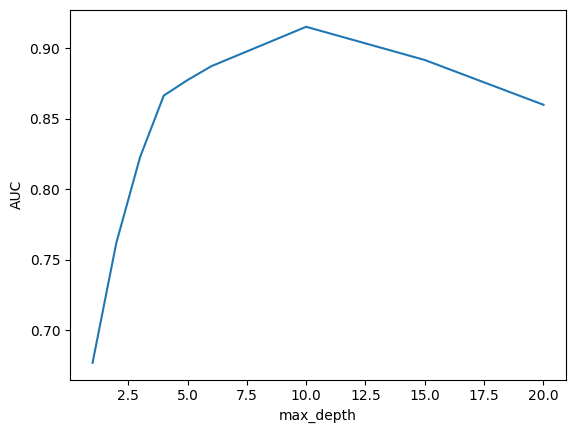

In [53]:
plt.plot(df_scores['max_depth'], df_scores['AUC'])
plt.xlabel('max_depth')
plt.ylabel('AUC')

In [54]:
min_samples_leaf = [1, 5, 10, 15, 20, 500, 100, 200]

mean_scores = []

for s in tqdm(min_samples_leaf, desc='min_samples_leaf'):
    scores = []
    
    for train_idx, val_idx in tqdm(kfold.split(df_full_train), desc='k', leave=False):
        df_train_temp = df_full_train.iloc[train_idx]
        df_val_temp = df_full_train.iloc[val_idx]

        y_train_temp = df_train_temp['booking_status'].values
        y_val_temp = df_val_temp['booking_status'].values

        df_train_temp = df_train_temp[features]
        df_val_temp = df_val_temp[features]

        train_dict_temp = df_train_temp.to_dict(orient='records')
        val_dict_temp = df_val_temp.to_dict(orient='records')

        dv = fit_dv(train_dict_temp)
        X_train = prepare_X(train_dict_temp, dv)
        model = train_decision_tree(X_train, y_train_temp, max_depth=10, min_samples_leaf=s)
        X_val = prepare_X(val_dict_temp, dv)
        y_pred_temp = predict(X_val, model)

        auc = roc_auc_score(y_val_temp, y_pred_temp)
        scores.append(auc)
    
    mean_scores.append(np.mean(scores))

min_samples_leaf:   0%|          | 0/8 [00:00<?, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

k: 0it [00:00, ?it/s]

In [55]:
scores = [*zip(min_samples_leaf, mean_scores)]
df_scores = pd.DataFrame(scores, columns=['min_samples_leaf', 'AUC'])
df_scores.sort_values(by='AUC', ascending=False)

,min_samples_leaf,AUC
3,15,0.917460
2,10,0.917373
1,5,0.917274
4,20,0.916321
0,1,0.915192
6,100,0.899524
7,200,0.889349
5,500,0.877507


In [56]:
dv = fit_dv(train_dict)
X_train = prepare_X(train_dict, dv)
dt = train_decision_tree(X_train, y_train, max_depth=10, min_samples_leaf=1)
print(export_text(dt, feature_names=[*dv.get_feature_names_out()]))

|--- lead_time <= 151.50
|   |--- no_of_special_requests <= 0.50
|   |   |--- market_segment_type=online <= 0.50
|   |   |   |--- lead_time <= 90.50
|   |   |   |   |--- avg_price_per_room <= 201.50
|   |   |   |   |   |--- lead_time <= 59.50
|   |   |   |   |   |   |--- market_segment_type=aviation <= 0.50
|   |   |   |   |   |   |   |--- arrival_month <= 9.50
|   |   |   |   |   |   |   |   |--- avg_price_per_room <= 63.29
|   |   |   |   |   |   |   |   |   |--- avg_price_per_room <= 59.75
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- avg_price_per_room >  59.75
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |--- avg_price_per_room >  63.29
|   |   |   |   |   |   |   |   |   |--- market_segment_type=corporate <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |   |   |--- market_segment_type=corporate >  0.50
|   |   |   |   |   |   |   |   |   |   |--- cla

### Random Forest: 5-Fold Cross-Validation

In [57]:
scores = []
for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train_temp = df_full_train.iloc[train_idx]
    df_val_temp = df_full_train.iloc[val_idx]

    y_train_temp = df_train_temp['booking_status'].values
    y_val_temp = df_val_temp['booking_status'].values

    df_train_temp = df_train_temp[features]
    df_val_temp = df_val_temp[features]

    train_dict_temp = df_train_temp.to_dict(orient='records')
    val_dict_temp = df_val_temp.to_dict(orient='records')

    dv = fit_dv(train_dict_temp)
    X_train = prepare_X(train_dict_temp, dv)
    model = train_random_forest(X_train, y_train_temp)
    X_val = prepare_X(val_dict_temp, dv)
    y_pred_temp = predict(X_val, model)

    auc = roc_auc_score(y_val_temp, y_pred_temp)
    scores.append(auc)

0it [00:00, ?it/s]

In [58]:
np.mean(scores).round(3), np.std(scores).round(3)

(0.937, 0.001)

### Random Forest: Parameters Tuning

In [59]:
scores = []

for d in tqdm([5, 10, 15], desc='max_depth'):
    for n in tqdm(range(10, 201, 10), desc='n_estimators', leave=False):
        df_train = df_train[features]
        df_val = df_val[features]

        train_dict = df_train.to_dict(orient='records')
        val_dict = df_val.to_dict(orient='records')

        dv = fit_dv(train_dict)
        X_train = prepare_X(train_dict, dv)
        rf = train_random_forest(X_train, y_train, n_estimators=n, max_depth=d)
        X_val = prepare_X(val_dict, dv)
        y_pred = predict(X_val, rf)
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

max_depth:   0%|          | 0/3 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

n_estimators:   0%|          | 0/20 [00:00<?, ?it/s]

In [60]:
columns = ['max_depth', 'n_estimators', 'AUC']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='AUC', ascending=False)

,max_depth,n_estimators,AUC
53,15,140,0.939577
59,15,200,0.939529
51,15,120,0.939528
58,15,190,0.939521
52,15,130,0.939520
54,15,150,0.939507
55,15,160,0.939504
48,15,90,0.939491
50,15,110,0.939471
56,15,170,0.939446


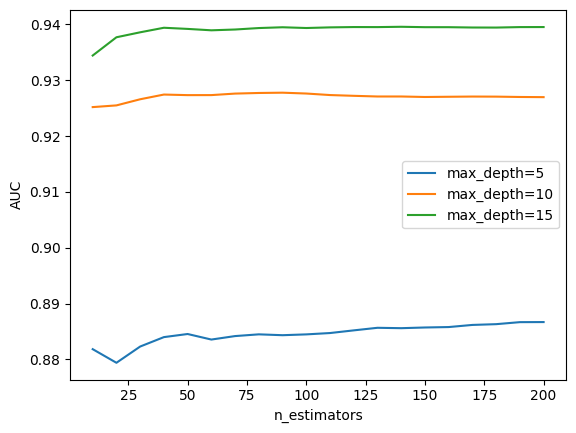

In [61]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset['n_estimators'], df_subset['AUC'],
             label='max_depth=%d' % d)

plt.xlabel('n_estimators')
plt.ylabel('AUC')
plt.legend()